In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from sklearn.linear_model import LinearRegression
from datetime import datetime

df = pd.read_csv('big_df_adj.csv')

In [30]:
years = mdates.YearLocator()
mon_base = df[['CME_RB1_FWd','CME_RB1_FWs']]

In [32]:
mon_base.columns=['DATE', 'AMBNS']
#note: AMBNS is so that the model is the same. This value is settle price for CME_RB1_FW

for i in range(len(mon_base)):
    mon_base['DATE'][i] = datetime.strptime(mon_base['DATE'][i], '%m/%d/%Y')

C:\Users\CliffConda\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\CliffConda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
mon_base=mon_base[::-1]

In [35]:
split = int(0.80 * len(mon_base))
train = mon_base[:split]
test = mon_base[split:]

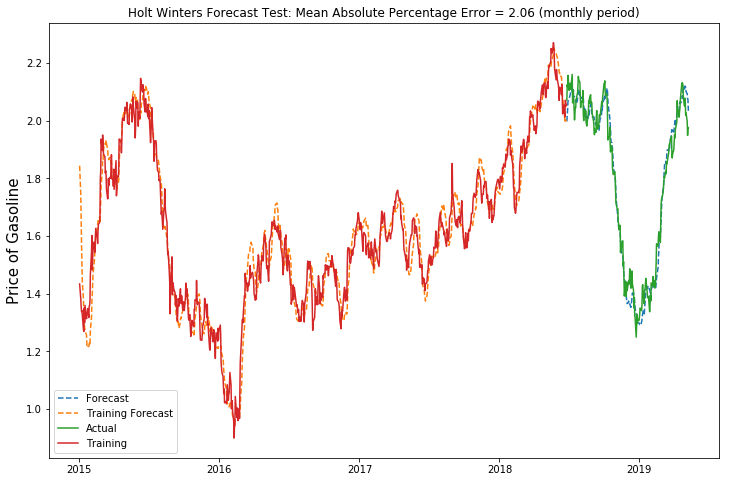

In [43]:
alpha = 0.2
beta = 0.08
gamma = 0.1

# Initialize the model
lr = LinearRegression(fit_intercept=True)
X = train.index.values.reshape(-1,1)
y = train.AMBNS.values.reshape(-1, 1)
lr.fit(X, y)

# Get level and trend from the regression
a_hat = np.array([lr.intercept_[0]])
b_hat = np.array([lr.coef_[0][0]])

p = 12 # Period
F_fit = np.ones(p)

y_hat = np.array([(a_hat + b_hat) * F_fit[0]])
for i in range(1, len(y)):
    a_hat = np.append(a_hat,
                     alpha * (y[i] / F_fit[i - p]) + (1 - alpha) * 
                      (a_hat[i - 1] + b_hat[i -1]))
    b_hat = np.append(b_hat,
                     beta * (a_hat[i] - a_hat[i - 1]) + 
                      b_hat[i - 1] * (1 - beta))
    F_fit = np.append(F_fit, 
                 gamma * (y[i] / a_hat[i]) + F_fit[i - p] * (1 - gamma))
    y_hat = np.append(y_hat, 
                      (a_hat[i] + b_hat[i]) * F_fit[i])
    
y_hat = y_hat.reshape(-1, 1)
mape_train = np.sum(np.abs(y_hat - y)) / np.sum(y) * 100

# Forecasting Model
y_test = test.AMBNS.values.reshape(-1, 1)

F = F_fit[-p:]
a_hat_test = np.array([a_hat[-1]])
b_hat_test = np.array([b_hat[-1]])
y_hat_test = np.array([(a_hat_test + b_hat_test) * F[0]])

for i in range(1, len(y_test)):
    a_hat_test = np.append(a_hat_test,
                     alpha * (y_test[i] / F[i - p]) + (1 - alpha) * 
                           (a_hat_test[i - 1] + b_hat_test[i - 1]))
    b_hat_test = np.append(b_hat_test,
                     beta * (a_hat_test[i] - a_hat_test[i - 1]) + 
                      b_hat_test[i - 1] * (1 - beta))
    F = np.append(F, 
                 gamma * (y_test[i] / a_hat_test[i]) + F[i - p] * (1 - gamma))
    y_hat_test = np.append(y_hat_test, 
                      (a_hat_test[i] + b_hat_test[i]) * F[i])
    
y_hat_test = y_hat_test.reshape(-1, 1)
mape = np.sum(np.abs(y_hat_test - y_test)) / np.sum(y_test) * 100

plt.figure(figsize=(12,8))
plt.plot(test['DATE'], y_hat_test, "--", label="Forecast")
plt.plot(train['DATE'], y_hat, "--", label="Training Forecast")
plt.plot(test['DATE'], test['AMBNS'], label="Actual")
plt.plot(train['DATE'], train['AMBNS'], label="Training")
plt.title("Holt Winters Forecast Test: Mean Absolute Percentage Error = %.2f (monthly period)" %mape)
plt.legend(loc="best")
plt.ylabel('Price of Gasoline', size=15)
plt.xticks(['1/1/2015', '1/1/2016', '1/1/2017','1/1/2018', '1/1/2019'])
plt.show()